In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [ ]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [44]:
def process_age(df):
    df['Age'] = df['Age'].fillna(-0.5)
    cut_points = [-1, 0, 5, 12, 18, 35, 60, 100]
    label_names = ['Missing', 'Infant', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
    df['Age_Range'] = pd.cut(df['Age'], cut_points, labels=label_names)
    return df

def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df,dummies], axis=1)
    return df

train = process_age(train)
holdout = process_age(holdout)

for feature in ('Age_Range', 'Pclass', 'Sex'):
    train = create_dummies(train, feature)
    holdout = create_dummies(holdout, feature)

print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled', 'Age_Range',
       'Age_Range_Missing', 'Age_Range_Infant', 'Age_Range_Child',
       'Age_Range_Teenager', 'Age_Range_Young Adult', 'Age_Range_Adult',
       'Age_Range_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female',
       'Sex_male'],
      dtype='object')


### Moar features

- *SibSp* - The number of siblings or spouses the passenger had aboard the Titanic
- *Parch* - The number of parents or children the passenger had aboard the Titanic
- *Ticket* - The passenger's ticket number
- *Fare* - The fair the passenger paid
- *Cabin* - The passengers cabin number
- *Embarked* - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

In [45]:
columns = ['Name', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
train[columns].head()

,Name,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,"Braund, Mr. Owen Harris",1,0,A/5 21171,7.2500,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,71.2833,C85,C
2,"Heikkinen, Miss. Laina",0,0,STON/O2. 3101282,7.9250,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,113803,53.1000,C123,S
4,"Allen, Mr. William Henry",0,0,373450,8.0500,NaN,S


*Name* and *Ticket* are unique to each passenger. Ignoring them for now...

In [46]:
columns = ['SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']
train[columns].describe(include='all', percentiles=[])

,SibSp,Parch,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,204,889
unique,NaN,NaN,NaN,147,3
top,NaN,NaN,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,4,644
mean,0.523008,0.381594,32.204208,NaN,NaN
std,1.102743,0.806057,49.693429,NaN,NaN
min,0.000000,0.000000,0.000000,NaN,NaN
50%,0.000000,0.000000,14.454200,NaN,NaN
max,8.000000,6.000000,512.329200,NaN,NaN


*Cabin* has values for only 204 of the 891 observations. Ignoring it too...

*Embarked* and *Pclass* are categorical features with only three unique values each.

*Pclass* have two missing values. Filling missing values with the most common value.

In [47]:
train['Pclass'] = train['Pclass'].fillna(train['Pclass'].mode())
holdout['Pclass'] = holdout['Pclass'].fillna(train['Pclass'].mode())

The holdout set has a missing value in the Fare column which we'll fill with the mean.

In [48]:
train['Fare'] = train['Fare'].fillna(train['Fare'].mean())
holdout['Fare'] = holdout['Fare'].fillna(train['Fare'].mean())

In [49]:
train[['SibSp', 'Parch', 'Fare']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp    891 non-null int64
Parch    891 non-null int64
Fare     891 non-null float64
dtypes: float64(1), int64(2)
memory usage: 21.0 KB


In [50]:
holdout['Fare'] = holdout['Fare'].fillna(train['Fare'].mean())

train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode())
holdout['Embarked'] = holdout['Embarked'].fillna(holdout['Embarked'].mode())

train = create_dummies(train, 'Embarked')
holdout = create_dummies(holdout, 'Embarked')

# don't like warnings ;p, avoiding them:
train['SibSp'] = np.float64(train['SibSp'])
train['Parch'] = np.float64(train['Parch'])
train['Fare'] = np.float64(train['Fare'])
holdout['SibSp'] = np.float64(holdout['SibSp'])
holdout['Parch'] = np.float64(holdout['Parch'])
holdout['Fare'] = np.float64(holdout['Fare'])

columns = ['SibSp','Parch','Fare']
for col in columns:
    train[col + '_scaled'] = minmax_scale(train[col])
    holdout[col + '_scaled'] = minmax_scale(holdout[col])

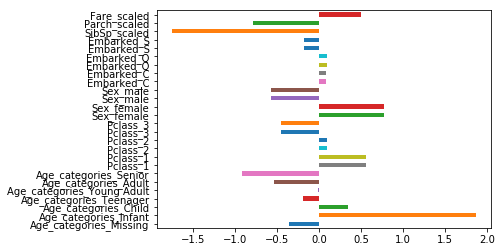

In [52]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
           'Age_categories_Child', 'Age_categories_Teenager',
           'Age_categories_Young Adult', 'Age_categories_Adult',
           'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 
           'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 
           'Embarked_Q', 'Embarked_S','SibSp_scaled', 'Parch_scaled',
           'Fare_scaled']

lr = LogisticRegression()
lr.fit(train[columns], train['Survived'])

coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0], index=train[columns].columns)
feature_importance.plot.barh()

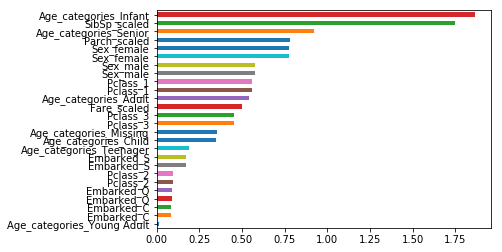

In [53]:
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

In [54]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
           'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

lr = LogisticRegression()
scores = cross_val_score(lr, train[columns], train['Survived'], cv=10)

accuracy = np.mean(scores)
print(accuracy)

0.814801952105


In [55]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
           'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

X = train[columns]
y = train['Survived']

lr = LogisticRegression()
lr.fit(X, y)

holdout_predictions = lr.predict(holdout[columns])

submission_df = {'PassengerId': holdout['PassengerId'], 'Survived': holdout_predictions}
submission = pd.DataFrame(submission_df)
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


### Creating the submission file

The file must have exactly 2 columns:
- PassengerId (sorted in any order)
- Survived (contains your binary predictions: 1 for survived, 0 for deceased)

In [56]:
submission.to_csv('submission_v2.csv', index=False)